In [1]:
import paho.mqtt.client as paho
import numpy as np
import random
import json
import networkx as nx
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# %matplotlib inline

In [2]:
broker_ip = '192.168.0.104'
broker_ip = 'localhost'
# broker_ip = '10.1.199.251'
# broker_ip = '10.101.6.111'
connflag = False

In [3]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)

    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']


    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    return plt, fig

In [4]:
mqttc = paho.Client()
counter = 0
N = 20
format_date = "%d %b %Y %H%M%S.%f"

def on_connect(client, userdata, flags, rc):
    global connflag
    #if connection is successful, rc value will be 0
    print("Connection returned result: " + str(rc) )
    connflag = True

def on_message(client, userdata, msg): 
    print("-t {} | -p {}".format(msg.topic, msg.payload.decode()) )
    
def on_state(client, userdata, msg): 
    global G, counter
    counter += 1
    name = datetime.now().strftime(format_date)
    js = json.loads(msg.payload.decode())
    G.node[js['pi_id']]['state'] = js['state']
    if counter%N == 0:
        plt, fig = plot(G, 'step {}'.format((counter-1)//N), **plt_set)
        fig.savefig('figures/{}.png'.format(name))
        plt.close()
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    print( log)
    with open("log.txt", "a") as myfile:
        myfile.write("{},{}\n".format(name, log))
        
def on_finish(client, userdata, msg):  # on finish step
    global node_set
    log = "-t {} | -p {}".format(msg.topic, msg.payload.decode())
    with open("log_node_set.txt", "a") as myfile:
        myfile.write("{}\n".format(log))
    node_id = msg.payload.decode()
    node_set.remove(node_id)
    print(node_set)
#     with open("log_node_set.txt", "a") as myfile:
#         myfile.write("{},{}\n".format(node_set))
    if len(node_set) == 0:
        mqttc.publish('next', 'dummy_msg', qos=2)
        node_set = {str(x) for x in range(N)}
    
    
node_set = {str(x) for x in range(N)}
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.message_callback_add("state", on_state)
mqttc.message_callback_add("finish", on_finish)

mqttc.connect(broker_ip)
mqttc.loop_start()
mqttc.subscribe('state', 2)
mqttc.subscribe('finish', 2)

(0, 2)

Connection returned result: 0


(6.714202358824712, 6.714202358824712) (1, 0)
Total node number 20


/home/dd/.virtualenvs/pi/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


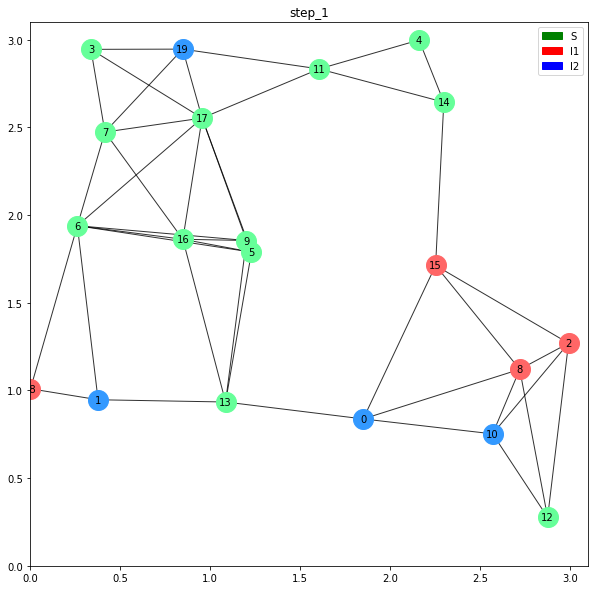

In [5]:
paramet = {
        'alpha': [0.5, 0.5], # infect rate 
        'mu': [0.5, 0.5], # sleep s 
        'gamma': [0.1, 0.1], # rec rate 
        'lambda': [0.7, 0.2], # sleep I1 
        'kappa': [0.7, 0.2] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
np.random.seed(315)  # structure
random.seed(6)       # infected
# N = 5
r = 1
number_subgraphs = 0

while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=4, I2_a=4, grid_size=[3,3], create=True) # net='Uniform Grid'
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

G = a.G
# G.node[0]['state'] = 'S_s'

plt_set = {
    'ns': 400, 
    'fs': 10,
    'lim': 3.1, 
    'figsize': (10,10)
}
plt, fig = plot(G, **plt_set) #  ns=300, fs=6,lim=5
# plt.show()
fig.savefig('figures/_.png')

In [6]:
G.node[1]

msg_list = []
for node_id in range(N):
    neighbours = list(G[node_id])
    msg = {
        "id": node_id,
        "state": G.node[node_id]['state'],
        "neighbours": neighbours
    }
    msg_list.append(msg)
    print(msg)
    
mqttc.publish('init', json.dumps(msg_list))

{'id': 0, 'state': 'I2_a', 'neighbours': [8, 10, 13, 15]}
{'id': 1, 'state': 'I2_a', 'neighbours': [6, 13, 18]}
{'id': 2, 'state': 'I1_a', 'neighbours': [8, 10, 12, 15]}
{'id': 3, 'state': 'S_a', 'neighbours': [7, 17, 19]}
{'id': 4, 'state': 'S_a', 'neighbours': [11, 14]}
{'id': 5, 'state': 'S_a', 'neighbours': [6, 9, 13, 16, 17]}
{'id': 6, 'state': 'S_a', 'neighbours': [1, 5, 7, 9, 16, 17, 18]}
{'id': 7, 'state': 'S_a', 'neighbours': [3, 6, 16, 17, 19]}
{'id': 8, 'state': 'I1_a', 'neighbours': [0, 2, 10, 12, 15]}
{'id': 9, 'state': 'S_a', 'neighbours': [5, 6, 13, 16, 17]}
{'id': 10, 'state': 'I2_a', 'neighbours': [0, 2, 8, 12]}
{'id': 11, 'state': 'S_a', 'neighbours': [4, 14, 17, 19]}
{'id': 12, 'state': 'S_a', 'neighbours': [2, 8, 10]}
{'id': 13, 'state': 'S_a', 'neighbours': [0, 1, 5, 9, 16]}
{'id': 14, 'state': 'S_a', 'neighbours': [4, 11, 15]}
{'id': 15, 'state': 'I1_a', 'neighbours': [0, 2, 8, 14]}
{'id': 16, 'state': 'S_a', 'neighbours': [5, 6, 7, 9, 13, 17]}
{'id': 17, 'state':

In [ ]:
# node_set = {str(x) for x in range(5)}
# mqttc.publish('finish', '14', qos=2)
node_set


In [ ]:
mqttc.loop_stop()

In [ ]:
mqttc.publish('next', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('stop', 'dummy_msg', qos=2)

In [ ]:
mqttc.publish('kill', 'process die', qos=2)

In [ ]:
mqttc.publish('paramet', json.dumps(paramet), qos=2)

In [7]:
mqttc.publish('start', 'dummy_msg', qos=2)

-t state | -p {"pi_id": 0, "step": 0, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 0, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 0, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 0, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 0, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 0, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 0, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 0, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 0, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 0, "state": "S_a"}
-t state | -p {"step": 0, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 0, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 0, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 0, "state": "I2_a", "pi_id": 19}
-t state | -p {"step": 0, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 0, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 0, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 0, "state": "S_a", "pi_id": 13}
-t state | -p

-t state | -p {"pi_id": 9, "step": 3, "state": "I2_a"}
{'18'}
set()
-t state | -p {"step": 4, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 4, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 4, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 4, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 4, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 4, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 4, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 4, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 4, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 4, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11'

-t state | -p {"step": 7, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 8, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 8, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 8, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 8, "state": "I2_a"}
-t state | -p {"pi_id": 4, "step": 8, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 8, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 8, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 8, "state": "I2_s"}
-t state | -p {"pi_id": 8, "step": 8, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 8, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3

-t state | -p {"step": 11, "state": "I1_a", "pi_id": 15}
{'14', '1'}
{'14'}
set()
-t state | -p {"pi_id": 0, "step": 12, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 12, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 12, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 12, "state": "I2_s"}
-t state | -p {"pi_id": 4, "step": 12, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 12, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 12, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 12, "state": "I2_s"}
-t state | -p {"pi_id": 8, "step": 12, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 12, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4'

-t state | -p {"step": 15, "state": "I2_s", "pi_id": 15}
{'10', '4'}
{'10'}
set()
-t state | -p {"step": 16, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 16, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 16, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 16, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 16, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 16, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 16, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 16, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 16, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 16, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5

-t state | -p {"pi_id": 9, "step": 19, "state": "I2_s"}
{'6', '17'}
{'6'}
set()
-t state | -p {"pi_id": 0, "step": 20, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 20, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 20, "state": "S_s"}
-t state | -p {"pi_id": 3, "step": 20, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 20, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 20, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 20, "state": "S_s"}
-t state | -p {"pi_id": 7, "step": 20, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 20, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 20, "state": "I2_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"step": 23, "state": "I1_s", "pi_id": 15}
{'4'}
set()
-t state | -p {"step": 24, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 24, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 24, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 24, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 24, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 24, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 24, "state": "I2_s", "pi_id": 12}
-t state | -p {"step": 24, "state": "I2_s", "pi_id": 13}
-t state | -p {"step": 24, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 24, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16'

-t state | -p {"pi_id": 9, "step": 27, "state": "I2_a"}
set()
-t state | -p {"pi_id": 0, "step": 28, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 28, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 28, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 28, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 28, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 28, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 28, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 28, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 28, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 28, "state": "I2_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '

-t state | -p {"pi_id": 9, "step": 31, "state": "I2_a"}
{'10', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '19'}
{'10', '18', '0', '8', '2', '12', '14', '15', '4', '11', '1', '19'}
{'10', '18', '0', '8', '2', '12', '14', '15', '4', '11', '1'}
{'10', '18', '0', '8', '2', '12', '14', '15', '4', '1'}
{'10', '18', '0', '8', '2', '12', '14', '15', '4'}
{'10', '18', '8', '2', '12', '14', '15', '4'}
{'10', '18', '8', '2', '14', '15', '4'}
{'10', '18', '2', '14', '15', '4'}
{'10', '18', '2', '15', '4'}
{'18', '2', '15', '4'}
{'18', '2', '15'}
{'18', '15'}
{'15'}
set()
-t state | -p {"pi_id": 0, "step": 32, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 32, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 32, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 32, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 32, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 32, "state": "I2_a"}


-t state | -p {"step": 35, "state": "I2_a", "pi_id": 15}
set()
-t state | -p {"step": 36, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 36, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 36, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 36, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 36, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 36, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 36, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 36, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 36, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 36, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4',

-t state | -p {"step": 39, "state": "S_a", "pi_id": 15}
{'8', '15', '4', '1'}
{'8', '4', '1'}
{'4', '1'}
{'1'}
set()
-t state | -p {"step": 40, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 40, "state": "I1_a", "pi_id": 17}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
-t state | -p {"step": 40, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 40, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 40, "state": "I2_s", "pi_id": 10}
-t state | -p {"step": 40, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 40, "state": "I2_a", "pi_id": 12}
-t s

-t state | -p {"pi_id": 9, "step": 43, "state": "I2_a"}
set()
-t state | -p {"pi_id": 0, "step": 44, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 44, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 44, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 44, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 44, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 44, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 44, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 44, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 44, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 44, "state": "I2_s"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17

-t state | -p {"pi_id": 9, "step": 47, "state": "I2_a"}
{'1'}
set()
-t state | -p {"pi_id": 0, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 4, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 5, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 48, "state": "I2_s"}
-t state | -p {"pi_id": 7, "step": 48, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 48, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 48, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1

-t state | -p {"pi_id": 9, "step": 51, "state": "I2_s"}
set()
-t state | -p {"pi_id": 0, "step": 52, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 52, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 2, "step": 52, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 52, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 52, "state": "I2_a"}
-t state | -p {"pi_id": 5, "step": 52, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 52, "state": "I2_s"}
-t state | -p {"pi_id": 7, "step": 52, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 52, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 52, "state": "I2_

-t state | -p {"step": 55, "state": "I2_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 56, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 56, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 56, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 56, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 56, "state": "I2_a"}
-t state | -p {"pi_id": 5, "step": 56, "state": "I2_s"}
-t state | -p {"pi_id": 6, "step": 56, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 56, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 56, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 56, "state": "I2_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1

-t state | -p {"pi_id": 0, "step": 60, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 60, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 60, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 60, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 60, "state": "I2_s"}
-t state | -p {"pi_id": 5, "step": 60, "state": "I2_s"}
-t state | -p {"pi_id": 6, "step": 60, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 60, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 60, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 60, "state": "I2_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14', '16',

-t state | -p {"pi_id": 9, "step": 63, "state": "I2_a"}
set()
-t state | -p {"step": 64, "state": "I2_s", "pi_id": 16}
-t state | -p {"step": 64, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 64, "state": "I2_s", "pi_id": 18}
-t state | -p {"step": 64, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 64, "state": "I2_s", "pi_id": 10}
-t state | -p {"step": 64, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 64, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 64, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 64, "state": "I2_a", "pi_id": 14}
-t state | -p {"step": 64, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4',

set()
-t state | -p {"pi_id": 0, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 68, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 68, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 68, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 68, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14'

-t state | -p {"pi_id": 9, "step": 71, "state": "I2_a"}
set()
-t state | -p {"pi_id": 0, "step": 72, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 72, "state": "I2_s"}
-t state | -p {"pi_id": 2, "step": 72, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 72, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 72, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 72, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 72, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 72, "state": "S_s"}
-t state | -p {"pi_id": 8, "step": 72, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 72, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '1

-t state | -p {"pi_id": 9, "step": 75, "state": "I2_a"}
set()
-t state | -p {"pi_id": 0, "step": 76, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 76, "state": "I2_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
-t state | -p {"pi_id": 2, "step": 76, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 76, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 76, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 76, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 76, "state": "I2_s"}
-t state | -p {"pi_id": 7, "step": 76, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 76, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 76, "state": "I2_a"}
-t state | -p {"step": 76, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 7

-t state | -p {"pi_id": 9, "step": 79, "state": "I2_s"}
set()
-t state | -p {"pi_id": 0, "step": 80, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 80, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 80, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 80, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 80, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 80, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 80, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 80, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 80, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 80, "state": "I2_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', 

-t state | -p {"pi_id": 9, "step": 83, "state": "I2_a"}
set()
-t state | -p {"pi_id": 0, "step": 84, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 84, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 84, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 84, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 84, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 84, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 84, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 84, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 84, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 84, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '

-t state | -p {"step": 88, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 88, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 88, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 88, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 88, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 88, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 88, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 88, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 88, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 88, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '14

-t state | -p {"step": 91, "state": "I2_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 92, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 92, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 92, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 3, "step": 92, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 92, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 92, "state": "I2_a"}
-t state | -p {"pi_id": 6, "step": 92, "state": "I2_s"}
-t state | -p {"pi_id": 7, "step": 92, "state": "I1_a"}
-t state | -p {"pi_id": 

-t state | -p {"pi_id": 9, "step": 95, "state": "I2_s"}
{'16', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 96, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 96, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 96, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 96, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 96, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 96, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 96, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 96, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 96, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 96, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4'

-t state | -p {"pi_id": 9, "step": 99, "state": "I2_a"}
set()
-t state | -p {"step": 100, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 100, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 100, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 100, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 100, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 100, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 100, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 100, "state": "S_s", "pi_id": 13}
-t state | -p {"step": 100, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 100, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', 

-t state | -p {"step": 104, "state": "I2_a", "pi_id": 16}
-t state | -p {"step": 104, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 104, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 104, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 104, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 104, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 104, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 104, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 104, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 104, "state": "S_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', 

-t state | -p {"step": 108, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 108, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 108, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 108, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 108, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 108, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 108, "state": "I2_s", "pi_id": 12}
-t state | -p {"step": 108, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 108, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 108, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8',

-t state | -p {"step": 111, "state": "I2_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 112, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 112, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 112, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 112, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 112, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 112, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 112, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 112, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 112, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 112, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '11', '1

-t state | -p {"step": 116, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 116, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 116, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 116, "state": "I2_a", "pi_id": 19}
-t state | -p {"step": 116, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 116, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 116, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 116, "state": "I2_a", "pi_id": 13}
-t state | -p {"step": 116, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 116, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2'

-t state | -p {"step": 120, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 120, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 120, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 120, "state": "I2_a", "pi_id": 19}
-t state | -p {"step": 120, "state": "S_s", "pi_id": 10}
-t state | -p {"step": 120, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 120, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 120, "state": "S_s", "pi_id": 13}
-t state | -p {"step": 120, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 120, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', 

-t state | -p {"step": 124, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 124, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 124, "state": "I2_a", "pi_id": 18}
-t state | -p {"step": 124, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 124, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 124, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 124, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 124, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 124, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 124, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '18', '0', '8', '2', '

-t state | -p {"pi_id": 9, "step": 127, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 128, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 128, "state": "S_s"}
-t state | -p {"pi_id": 2, "step": 128, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 128, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 128, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 128, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 128, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 128, "state": "I2_a"}
-t state | -p {"pi_id": 8, "step": 128, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 128, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11'

-t state | -p {"pi_id": 9, "step": 131, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 132, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 132, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 132, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 132, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 132, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 132, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 132, "state": "I2_a"}
-t state | -p {"pi_id": 7, "step": 132, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 132, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 132, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '

-t state | -p {"pi_id": 9, "step": 135, "state": "I2_s"}
set()
-t state | -p {"pi_id": 0, "step": 136, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 136, "state": "I2_a"}
-t state | -p {"pi_id": 2, "step": 136, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 136, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 136, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 136, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 136, "state": "I2_s"}
-t state | -p {"pi_id": 7, "step": 136, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 136, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 136, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1

-t state | -p {"step": 139, "state": "I2_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 140, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 140, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 140, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 140, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 140, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 140, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 140, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 140, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 140, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 140, "state": "S_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', 

-t state | -p {"pi_id": 0, "step": 144, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 144, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 144, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 144, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 144, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 144, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 144, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 144, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 144, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 144, "state": "I1_s"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9',

-t state | -p {"pi_id": 9, "step": 147, "state": "I1_s"}
set()
-t state | -p {"pi_id": 0, "step": 148, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 148, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 148, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 148, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 148, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 148, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 148, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 148, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 148, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 148, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11',

-t state | -p {"pi_id": 9, "step": 151, "state": "S_a"}
{'6'}
set()
-t state | -p {"pi_id": 0, "step": 152, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 152, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 152, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 152, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 152, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 152, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 152, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 152, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 152, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 152, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"step": 155, "state": "I2_a", "pi_id": 15}
{'1'}
set()
-t state | -p {"pi_id": 0, "step": 156, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 156, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 156, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 156, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 156, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 156, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 156, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 156, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 156, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 156, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '

-t state | -p {"pi_id": 0, "step": 160, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 160, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 160, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 160, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 160, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 160, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 160, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 160, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 160, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 160, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '5', '9',

-t state | -p {"pi_id": 9, "step": 163, "state": "I1_a"}
{'14'}
set()
-t state | -p {"pi_id": 0, "step": 164, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 164, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 164, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 164, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 164, "state": "I2_s"}
-t state | -p {"pi_id": 5, "step": 164, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 164, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 164, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 164, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 164, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4',

{'15', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 168, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 168, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 168, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 168, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 168, "state": "I2_a"}
-t state | -p {"pi_id": 5, "step": 168, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 168, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 168, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 168, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 168, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2

-t state | -p {"pi_id": 0, "step": 172, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 172, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 172, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 172, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 172, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 172, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 172, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 172, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 172, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 172, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '18', '0', '2', '12', '5',

-t state | -p {"pi_id": 9, "step": 175, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 176, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 176, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 176, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 176, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 176, "state": "I1_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '

-t state | -p {"step": 179, "state": "I2_a", "pi_id": 15}
{'12', '14', '16', '4', '11', '19'}
{'12', '14', '16', '4', '11'}
{'12', '14', '16', '4'}
{'12', '16', '4'}
{'12', '4'}
{'12'}
set()
-t state | -p {"pi_id": 0, "step": 180, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 180, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 180, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 180, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 180, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 180, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 180, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 180, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 180, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 180, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', 

-t state | -p {"step": 184, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 184, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 184, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 184, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 184, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 184, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 184, "state": "I2_s", "pi_id": 12}
-t state | -p {"step": 184, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 184, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 184, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '18', '0', '8', '2', '1

-t state | -p {"step": 188, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 188, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 188, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 188, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 188, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 188, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 188, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 188, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 188, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 188, "state": "I2_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8',

-t state | -p {"pi_id": 9, "step": 191, "state": "I1_a"}
{'0', '6', '19'}
{'0', '6'}
{'0'}
set()
-t state | -p {"pi_id": 0, "step": 192, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 192, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 192, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"step": 192, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 192, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 192, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 192, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 192, "state":

-t state | -p {"pi_id": 9, "step": 195, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 196, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 196, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 196, "state": "I2_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"step": 196, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 196, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 196, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 196, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 196, "state": "I2_s", "pi_id": 10}
-t state | 

-t state | -p {"step": 199, "state": "S_a", "pi_id": 15}
{'15'}
set()
-t state | -p {"pi_id": 0, "step": 200, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 200, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 200, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 200, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 200, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 200, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 200, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 200, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 200, "state": "I2_s"}
-t state | -p {"pi_id": 9, "step": 200, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"step": 200, "state": "I1_s", "pi_id": 16}
{'3',

-t state | -p {"step": 203, "state": "S_s", "pi_id": 15}
{'8'}
set()
-t state | -p {"pi_id": 0, "step": 204, "state": "I2_s"}
-t state | -p {"pi_id": 1, "step": 204, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 204, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 204, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 204, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 204, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 204, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 204, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 204, "state": "S_s"}
-t state | -p {"pi_id": 9, "step": 204, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"pi_id": 9, "step": 207, "state": "I1_a"}
set()
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 208, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 208, "state": "I2_s", "pi_id": 10}
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 208, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 208, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 208, "state": "S_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16',

-t state | -p {"pi_id": 9, "step": 211, "state": "I1_a"}
{'12', '17'}
{'12'}
set()
-t state | -p {"step": 212, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 212, "state": "I2_s", "pi_id": 10}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 212, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 212, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 212, "state": "S_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12

-t state | -p {"pi_id": 9, "step": 215, "state": "I1_a"}
{'15', '13'}
{'15'}
set()
-t state | -p {"step": 216, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 216, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 216, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 216, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 216, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 216, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 216, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 216, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 216, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 216, "state": "S_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12

-t state | -p {"pi_id": 9, "step": 219, "state": "I1_s"}
set()
-t state | -p {"pi_id": 0, "step": 220, "state": "I2_a"}
-t state | -p {"pi_id": 1, "step": 220, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 220, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 220, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 220, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 220, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 220, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 220, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 220, "state": "I2_a"}
-t state | -p {"pi_id": 9, "step": 220, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '

-t state | -p {"step": 224, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 224, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 224, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 224, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 224, "state": "I2_s", "pi_id": 10}
-t state | -p {"step": 224, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 224, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 224, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 224, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 224, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '

-t state | -p {"pi_id": 9, "step": 227, "state": "S_a"}
{'13'}
set()
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 228, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 228, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 228, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 228, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 228, "state": "I2_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15

-t state | -p {"step": 232, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 232, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 232, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 232, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 232, "state": "I2_a", "pi_id": 10}
-t state | -p {"step": 232, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 232, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 232, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 232, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 232, "state": "I2_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', 

-t state | -p {"pi_id": 9, "step": 235, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 236, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 236, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 236, "state": "I2_s"}
-t state | -p {"pi_id": 3, "step": 236, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 236, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 236, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 236, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 236, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 236, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 236, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1

-t state | -p {"pi_id": 9, "step": 239, "state": "I1_s"}
{'10'}
set()
-t state | -p {"pi_id": 0, "step": 240, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 240, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 240, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 240, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 240, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 240, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 240, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 240, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 240, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 240, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4'

-t state | -p {"pi_id": 9, "step": 243, "state": "I1_a"}
set()
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 244, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 244, "state": "I2_a", "pi_id": 12}
-t state | -p {"step": 244, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 244, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 244, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15

-t state | -p {"pi_id": 9, "step": 247, "state": "I1_s"}
set()
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 248, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 248, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 248, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 248, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 248, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"pi_id": 9, "step": 251, "state": "I1_a"}
{'10'}
set()
-t state | -p {"pi_id": 0, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 252, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 252, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 252, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 252, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"step": 256, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 256, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 256, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 256, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 256, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 256, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 256, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 256, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 256, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 256, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', 

set()
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 260, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 260, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 260, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 260, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8'

-t state | -p {"pi_id": 0, "step": 264, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 264, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 264, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 264, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '19'}
-t state | -p {"pi_id": 4, "step": 264, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 264, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 264, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 264, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 264, "state": "I1_s"}
-t state | -p {"pi_id":

-t state | -p {"step": 267, "state": "S_a", "pi_id": 15}
{'15'}
set()
-t state | -p {"pi_id": 0, "step": 268, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 268, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 268, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 268, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 268, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 268, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 268, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 268, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 268, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 268, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', 

-t state | -p {"pi_id": 0, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 272, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 272, "state": "I2_a"}
-t state | -p {"pi_id": 3, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 272, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 272, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14',

-t state | -p {"step": 275, "state": "I1_s", "pi_id": 15}
{'2', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 276, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 276, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 276, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 276, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 276, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 276, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 276, "state": "S_s"}
-t state | -p {"pi_id": 7, "step": 276, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 276, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 276, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14'

-t state | -p {"step": 279, "state": "I1_a", "pi_id": 15}
{'11'}
set()
-t state | -p {"pi_id": 0, "step": 280, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 280, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 280, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 280, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 280, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 280, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 280, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 280, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 280, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 280, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '14', '15', '16', 

-t state | -p {"pi_id": 9, "step": 283, "state": "I1_s"}
set()
-t state | -p {"step": 284, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 284, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 284, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', 

-t state | -p {"pi_id": 9, "step": 287, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 288, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 288, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 288, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 288, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 288, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 288, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 288, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 288, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 288, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 288, "state": "S_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4'

-t state | -p {"step": 292, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 292, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 292, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 292, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 292, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 292, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 292, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 292, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 292, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 292, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2'

-t state | -p {"pi_id": 9, "step": 295, "state": "I1_a"}
{'14'}
set()
-t state | -p {"step": 296, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 296, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 296, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 296, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 296, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 296, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 296, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 296, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 296, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 296, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14',

-t state | -p {"pi_id": 9, "step": 299, "state": "I1_a"}
set()
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 300, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 300, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 300, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16',

-t state | -p {"step": 303, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 304, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 304, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 304, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 304, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15'

-t state | -p {"pi_id": 9, "step": 307, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 308, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 308, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 308, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 308, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 308, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', 

-t state | -p {"pi_id": 9, "step": 311, "state": "I1_a"}
{'18'}
set()
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 312, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 312, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 312, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '9', '14', '15

-t state | -p {"pi_id": 0, "step": 316, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 316, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 316, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 316, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 316, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 316, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 316, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 316, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 316, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 316, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', 

-t state | -p {"step": 319, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 320, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 320, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 320, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 320, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 320, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 320, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 320, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 320, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 320, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 320, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '

-t state | -p {"pi_id": 0, "step": 324, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 324, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 324, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 324, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 324, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '1

-t state | -p {"pi_id": 0, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 328, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 328, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 328, "state": "S_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '6', '5', '9', 

-t state | -p {"pi_id": 9, "step": 331, "state": "I1_a"}
{'5'}
set()
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 332, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 332, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15

-t state | -p {"pi_id": 9, "step": 335, "state": "I1_a"}
set()
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 336, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 336, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 336, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 336, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '

-t state | -p {"step": 339, "state": "I1_s", "pi_id": 15}
{'9', '4', '19'}
{'9', '19'}
{'19'}
set()
-t state | -p {"step": 340, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 340, "state": "S_s", "pi_id": 19}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 340, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 340, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18

-t state | -p {"step": 343, "state": "I1_s", "pi_id": 15}
{'13'}
set()
-t state | -p {"step": 344, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 344, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 344, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 344, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 344, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 344, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 344, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 344, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 344, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 344, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15'

-t state | -p {"pi_id": 0, "step": 348, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 348, "state": "S_s"}
-t state | -p {"pi_id": 2, "step": 348, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 348, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 348, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 348, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 348, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 348, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 348, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 348, "state": "I1_s"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '18', '0', '2', '12', '5', '9', '14'

-t state | -p {"step": 352, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 352, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 352, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 352, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 352, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 352, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 352, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 352, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 352, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 352, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '

-t state | -p {"pi_id": 0, "step": 356, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 356, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 356, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 3, "step": 356, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 356, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 356, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 356, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 356, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 356, "state": "I1_a"}
-t state | -p {"pi_id":

-t state | -p {"pi_id": 9, "step": 359, "state": "I1_a"}
{'18'}
set()
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 360, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 360, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 360, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 360, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 360, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9

set()
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 364, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 364, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 364, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8

-t state | -p {"step": 367, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 368, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 368, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 368, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 368, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15

-t state | -p {"step": 371, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 372, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 372, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 372, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 372, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 372, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '1

-t state | -p {"step": 376, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 376, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 376, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 376, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 376, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 376, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 376, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 376, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 376, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 376, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', 

-t state | -p {"step": 379, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 380, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 380, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 380, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 380, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 380, "state": "I1_s"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11',

-t state | -p {"pi_id": 9, "step": 383, "state": "I1_a"}
{'14'}
set()
-t state | -p {"step": 384, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 384, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 384, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 384, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 384, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9',

-t state | -p {"pi_id": 0, "step": 388, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 388, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 388, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 388, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 388, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 388, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 388, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 388, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 388, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 388, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14',

-t state | -p {"step": 391, "state": "I1_s", "pi_id": 15}
{'1'}
set()
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 392, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 392, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 392, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14

-t state | -p {"step": 395, "state": "I1_a", "pi_id": 15}
{'0'}
set()
-t state | -p {"pi_id": 0, "step": 396, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 396, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 396, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 396, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 396, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', 

-t state | -p {"pi_id": 0, "step": 400, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 400, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 400, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 400, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 400, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 400, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 400, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 400, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 400, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 400, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '

-t state | -p {"step": 403, "state": "I1_a", "pi_id": 15}
{'4'}
set()
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 404, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 404, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15

-t state | -p {"step": 407, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 408, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 408, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 408, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 408, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 408, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '14', '15',

-t state | -p {"step": 411, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 412, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 412, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 412, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 412, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', 

-t state | -p {"step": 415, "state": "I1_a", "pi_id": 15}
{'1'}
set()
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 416, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14'

{'10', '19'}
{'10'}
set()
-t state | -p {"step": 420, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 420, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 420, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 420, "state": "S_s", "pi_id": 19}
-t state | -p {"step": 420, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 420, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 420, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 420, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 420, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 420, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'

-t state | -p {"pi_id": 9, "step": 423, "state": "I1_a"}
set()
-t state | -p {"step": 424, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 424, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"step": 427, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"step": 428, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 428, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 428, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 428, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '17'}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', 

-t state | -p {"step": 431, "state": "I1_s", "pi_id": 15}
{'14'}
set()
-t state | -p {"pi_id": 0, "step": 432, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 432, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 432, "state": "S_s"}
-t state | -p {"pi_id": 3, "step": 432, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 432, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 432, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 432, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 432, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 432, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 432, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', 

-t state | -p {"step": 435, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 436, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 436, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 436, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 436, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '

set()
-t state | -p {"step": 440, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 440, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 440, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 440, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '6', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', 

-t state | -p {"step": 443, "state": "I1_a", "pi_id": 15}
{'17'}
set()
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 444, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 444, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 444, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 444, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '

-t state | -p {"step": 447, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 448, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 448, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 448, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 448, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 448, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', 

-t state | -p {"pi_id": 0, "step": 452, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 452, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 452, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 452, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 452, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 452, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 452, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 452, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 452, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 452, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '1

-t state | -p {"step": 455, "state": "I1_a", "pi_id": 15}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 456, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 456, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 456, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 456, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 456, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', 

-t state | -p {"pi_id": 9, "step": 459, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 460, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 460, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 460, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11

-t state | -p {"pi_id": 0, "step": 464, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 464, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 2, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 464, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 464, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 464, "state": "I1_a"}
-t state | -p {"step": 464, "state": "I1_a", "p

-t state | -p {"pi_id": 9, "step": 467, "state": "I1_a"}
set()
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 468, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"pi_id": 0, "step": 472, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 472, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 472, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 472, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 472, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '6', '5', '9', '14', '15

{'19', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 476, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 476, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 476, "state": "S_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', 

-t state | -p {"pi_id": 9, "step": 479, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 480, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 480, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 480, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 480, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 480, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 480, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 480, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 480, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 480, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 480, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '11', 

-t state | -p {"pi_id": 0, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 484, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 484, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 484, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '1

-t state | -p {"step": 488, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 488, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 488, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2',

-t state | -p {"step": 491, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 492, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 492, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 492, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15',

-t state | -p {"step": 496, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 496, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 496, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 496, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 496, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', 

-t state | -p {"step": 500, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 500, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 500, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 500, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 500, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 500, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 500, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 500, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 500, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 500, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2'

-t state | -p {"pi_id": 0, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 504, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 504, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 504, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 504, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 504, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14'

-t state | -p {"pi_id": 9, "step": 507, "state": "I1_a"}
set()
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 508, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 508, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 508, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16'

-t state | -p {"step": 511, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 512, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 512, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 512, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 512, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 512, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 512, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 512, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 512, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 512, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 512, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '7', '18', '0', '8', '2', '12', '14', '15', '16'

-t state | -p {"step": 516, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 516, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 516, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 516, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 516, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', 

-t state | -p {"step": 520, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 520, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 520, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 520, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2',

-t state | -p {"pi_id": 0, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 524, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 524, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 524, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 524, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '

-t state | -p {"step": 527, "state": "I1_a", "pi_id": 15}
{'9', '14', '4'}
{'9', '14'}
{'14'}
set()
-t state | -p {"pi_id": 0, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 528, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 528, "state": "S_s"}
-t state | -p {"pi_id": 7, "step": 528, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 528, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 528, "state": "S_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', 

-t state | -p {"step": 532, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 532, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 532, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 532, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 532, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 532, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 532, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 532, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 532, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 532, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '

-t state | -p {"pi_id": 0, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 536, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 536, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 536, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '18', '0', '2', '12', '5', '9', '14'

{'4', '1'}
{'1'}
set()
-t state | -p {"pi_id": 0, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 540, "state": "S_s"}
-t state | -p {"pi_id": 2, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 540, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 540, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 540, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 540, "state": "I1_s"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '18', '0'

-t state | -p {"step": 543, "state": "I1_a", "pi_id": 15}
{'1'}
set()
-t state | -p {"pi_id": 0, "step": 544, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 544, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 544, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 544, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 544, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 544, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 544, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 544, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 544, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 544, "state": "I1_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16

-t state | -p {"step": 547, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 548, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 548, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 548, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 548, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11'

-t state | -p {"step": 551, "state": "I1_a", "pi_id": 15}
{'4', '19'}
{'19'}
set()
-t state | -p {"pi_id": 0, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 552, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 552, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 552, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 552, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 552, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14',

-t state | -p {"pi_id": 9, "step": 555, "state": "I1_a"}
{'17'}
set()
-t state | -p {"pi_id": 0, "step": 556, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 556, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 556, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 3, "step": 556, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 556, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 556, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 556, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 556, "state": "I1_a"}
-t state 

-t state | -p {"step": 559, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 560, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 560, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 560, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 560, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 560, "state": "I1_s"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', 

set()
-t state | -p {"pi_id": 0, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 564, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 564, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 564, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 564, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', 

-t state | -p {"pi_id": 9, "step": 567, "state": "I1_a"}
{'18'}
set()
-t state | -p {"pi_id": 0, "step": 568, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 568, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 568, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 568, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 568, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 568, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 568, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 568, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 568, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 568, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"step": 572, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 572, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 572, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 572, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 572, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', 

-t state | -p {"step": 575, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 576, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 576, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 576, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11

-t state | -p {"step": 580, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 580, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 580, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 580, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 580, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '

-t state | -p {"step": 584, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 584, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 584, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 584, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '

-t state | -p {"step": 588, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 588, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 588, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 588, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 588, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 588, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 588, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 588, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 588, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 588, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '7', '18', '0', '8', '2

-t state | -p {"pi_id": 9, "step": 591, "state": "I1_a"}
{'3', '12', '19'}
{'3', '12'}
{'3'}
set()
-t state | -p {"pi_id": 0, "step": 592, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 592, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 592, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 592, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 592, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 592, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 592, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 592, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 592, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 592, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5

-t state | -p {"pi_id": 9, "step": 595, "state": "I1_a"}
{'3', '5', '19'}
{'3', '19'}
{'19'}
set()
-t state | -p {"pi_id": 0, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 596, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 596, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 596, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 596, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6',

-t state | -p {"pi_id": 9, "step": 599, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 600, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 600, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 600, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 600, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 600, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11

-t state | -p {"step": 604, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 604, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 604, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 604, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8'

-t state | -p {"pi_id": 0, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 608, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 608, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 608, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 608, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '1

-t state | -p {"step": 612, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 612, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 612, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 612, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 612, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 612, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 612, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 612, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 612, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 612, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '

-t state | -p {"step": 615, "state": "S_a", "pi_id": 15}
{'9', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 616, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 616, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 616, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 616, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 616, "state": "S_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '14', '15',

-t state | -p {"pi_id": 9, "step": 619, "state": "I1_a"}
{'18', '12'}
{'12'}
set()
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 620, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 620, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 620, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 620, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '1

-t state | -p {"step": 624, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 624, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 624, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 624, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 624, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '8', '2', '12'

-t state | -p {"pi_id": 0, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 628, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 628, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 628, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 628, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', 

-t state | -p {"step": 632, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 632, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 632, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 632, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8'

-t state | -p {"pi_id": 0, "step": 636, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 636, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 636, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 636, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 636, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 636, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 636, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 636, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 636, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 636, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', 

-t state | -p {"pi_id": 9, "step": 639, "state": "I1_a"}
set()
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 640, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 640, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 640, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 640, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15',

-t state | -p {"step": 643, "state": "I1_a", "pi_id": 15}
{'0'}
set()
-t state | -p {"pi_id": 0, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 644, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 644, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 644, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 644, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 644, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4

-t state | -p {"step": 648, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 648, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 648, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 648, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1'}
{'10', '3', '7', '18', '0', '8', '2'

-t state | -p {"pi_id": 9, "step": 651, "state": "I1_s"}
{'12', '14', '16'}
{'12', '16'}
{'12'}
set()
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 652, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 652, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 652, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 652, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 652, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', 

{'12', '14'}
{'12'}
set()
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 656, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 656, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 656, "state": "S_s", "pi_id": 14}
-t state | -p {"step": 656, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'1

-t state | -p {"pi_id": 9, "step": 659, "state": "I1_a"}
{'0', '14'}
{'14'}
set()
-t state | -p {"step": 660, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 660, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 660, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 660, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 660, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12'

{'2'}
set()
-t state | -p {"pi_id": 0, "step": 664, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 664, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 664, "state": "S_s"}
-t state | -p {"pi_id": 3, "step": 664, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 664, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 664, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 664, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 664, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 664, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 664, "state": "I1_s"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '2', '12', '

-t state | -p {"step": 668, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 668, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 668, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 668, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', 

set()
-t state | -p {"pi_id": 0, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 672, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 672, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 672, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 672, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12', '5', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '2', '12

-t state | -p {"pi_id": 9, "step": 675, "state": "S_a"}
{'12'}
set()
-t state | -p {"pi_id": 0, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 676, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 676, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 676, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '

-t state | -p {"step": 679, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 680, "state": "S_a"}
-t state | -p {"pi_id": 1, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 680, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 680, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 680, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 680, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', 

-t state | -p {"step": 683, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 684, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 684, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 684, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 684, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 684, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11',

-t state | -p {"pi_id": 9, "step": 687, "state": "I1_a"}
set()
-t state | -p {"pi_id": 0, "step": 688, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 688, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 688, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 688, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 688, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 688, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 688, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 688, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 688, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 688, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '

-t state | -p {"pi_id": 9, "step": 691, "state": "I1_s"}
set()
-t state | -p {"pi_id": 0, "step": 692, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 692, "state": "I1_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 2, "step": 692, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 692, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 692, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 692, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 692, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 692, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 692, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 692, "state": "I1_s"}
-t state | -p {"step": 692, "state": "I1_a", "pi_id": 16}
-t state | -p

-t state | -p {"step": 696, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 696, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 696, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 696, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 696, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 696, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 696, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 696, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 696, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 696, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8'

-t state | -p {"step": 700, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 700, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 700, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2'

-t state | -p {"step": 704, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 704, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 704, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 704, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 704, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 704, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 704, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 704, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 704, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 704, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '11', '1', '17'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '4', '1', '17'}
{'10', '3', '7', '18', '0', '8', '2',

-t state | -p {"step": 708, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 708, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '18', '0', '8', '2', 

-t state | -p {"step": 712, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 712, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 712, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 712, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 712, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '

-t state | -p {"step": 716, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 716, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 716, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2

-t state | -p {"step": 719, "state": "I1_a", "pi_id": 15}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 720, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 720, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 720, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 720, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', 

-t state | -p {"step": 724, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 724, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 724, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 724, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 724, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '14', '15', '4', '11', '1', '19', '13'}
{'10', '7', '18', '0', '8', '2',

-t state | -p {"pi_id": 9, "step": 727, "state": "I1_s"}
{'3', '7', '19'}
{'3', '7'}
{'3'}
set()
-t state | -p {"pi_id": 0, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 728, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 728, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 728, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 728, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 728, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '

-t state | -p {"step": 732, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 732, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 732, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 732, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 732, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 732, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 732, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 732, "state": "S_s", "pi_id": 13}
-t state | -p {"step": 732, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 732, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8',

-t state | -p {"pi_id": 9, "step": 735, "state": "I1_s"}
set()
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 736, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 736, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15

-t state | -p {"pi_id": 9, "step": 739, "state": "I1_a"}
{'3'}
set()
-t state | -p {"pi_id": 0, "step": 740, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 740, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 740, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 740, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 740, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 740, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 740, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 740, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 740, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 740, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '1

-t state | -p {"step": 744, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 744, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 744, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 744, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 744, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2',

-t state | -p {"pi_id": 9, "step": 747, "state": "I1_a"}
set()
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 748, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 748, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 748, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 748, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '7', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"step": 752, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 752, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 752, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 752, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 752, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2

-t state | -p {"step": 756, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 756, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 756, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 756, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '

-t state | -p {"step": 760, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 760, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 760, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 760, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 760, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 760, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 760, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 760, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 760, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 760, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '18', '0', '8', '2', '1

-t state | -p {"step": 763, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 764, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 764, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 764, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 764, "state": "S_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '

-t state | -p {"step": 768, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 768, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 768, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 768, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 768, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 768, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 768, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 768, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 768, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 768, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '18', '0', '8', '2', 

-t state | -p {"step": 771, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 772, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 772, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 772, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 772, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 772, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 772, "state": "S_s", "pi_id": 11}
-t state | -p {"step": 772, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 772, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 772, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 772, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '

-t state | -p {"pi_id": 0, "step": 776, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 776, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 776, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', 

-t state | -p {"step": 779, "state": "I1_a", "pi_id": 15}
{'10', '14'}
{'14'}
set()
-t state | -p {"pi_id": 0, "step": 780, "state": "S_s"}
-t state | -p {"pi_id": 1, "step": 780, "state": "I1_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
-t state | -p {"pi_id": 2, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 780, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 780, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 780, "state": "I1_a"}
-t state | -p {"step": 780, "state": "I1_a", "pi_i

-t state | -p {"pi_id": 0, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 784, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 784, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 784, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 784, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14'

-t state | -p {"step": 788, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 788, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 788, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 788, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 788, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2'

-t state | -p {"step": 791, "state": "S_a", "pi_id": 15}
set()
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 792, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 792, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 792, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15'

-t state | -p {"step": 795, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 796, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 796, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 796, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 796, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 796, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 796, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 796, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 796, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 796, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 796, "state": "I1_a"}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', 

-t state | -p {"pi_id": 9, "step": 799, "state": "I1_a"}
set()
-t state | -p {"step": 800, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 800, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 800, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 800, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 800, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 800, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 800, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 800, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 800, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 800, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16'

-t state | -p {"step": 803, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 804, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 804, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 804, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 804, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"pi_id": 0, "step": 808, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 808, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 808, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 808, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 808, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 808, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 808, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 808, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 808, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 808, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14'

-t state | -p {"step": 812, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 812, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 812, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 812, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 812, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2',

-t state | -p {"pi_id": 0, "step": 816, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 816, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 816, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 816, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 816, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 816, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 816, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 816, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 816, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 816, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '5', '9', '

{'3', '4'}
{'4'}
set()
-t state | -p {"step": 820, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 820, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 820, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 820, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 820, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 820, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 820, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 820, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 820, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 820, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10

-t state | -p {"pi_id": 9, "step": 823, "state": "I1_a"}
{'18'}
set()
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 824, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 824, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 824, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15

-t state | -p {"pi_id": 0, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 828, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 828, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 828, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 828, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 828, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14',

-t state | -p {"step": 831, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 832, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 832, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 832, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 832, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'10', '3', '7', '0', '2', '12', '6', '5', '9', '14', '16', '4', '

-t state | -p {"pi_id": 0, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 836, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 836, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 836, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 836, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9',

-t state | -p {"pi_id": 0, "step": 840, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 840, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 840, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 840, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 840, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', 

-t state | -p {"pi_id": 9, "step": 843, "state": "I1_a"}
set()
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 844, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 844, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 844, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '

-t state | -p {"step": 848, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 848, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 848, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', 

-t state | -p {"step": 852, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 852, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 852, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 852, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 852, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 852, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 852, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 852, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 852, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 852, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', 

{'3', '0', '2', '5', '4'}
{'3', '0', '2', '4'}
{'3', '2', '4'}
{'3', '4'}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 856, "state": "S_s"}
-t state | -p {"pi_id": 2, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 856, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 856, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 856, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 856, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', 

-t state | -p {"step": 859, "state": "I1_a", "pi_id": 15}
{'16', '4'}
{'16'}
set()
-t state | -p {"step": 860, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 860, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 860, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 860, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 860, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12

-t state | -p {"pi_id": 0, "step": 864, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 864, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 864, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 864, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 864, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 864, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 864, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 864, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 864, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 864, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '6', '5', '9', '14'

-t state | -p {"pi_id": 0, "step": 868, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 868, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 868, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 868, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 868, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 868, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 868, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 868, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 868, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 868, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '

{'14'}
set()
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 872, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 872, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 872, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '1

-t state | -p {"step": 875, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 876, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 876, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 876, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 876, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 876, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 876, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 876, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1

-t state | -p {"pi_id": 9, "step": 879, "state": "I1_a"}
{'3'}
set()
-t state | -p {"pi_id": 0, "step": 880, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 880, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 880, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 880, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 880, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 880, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 880, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 880, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 880, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 880, "state": "I1_s"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4

{'14'}
set()
-t state | -p {"pi_id": 0, "step": 884, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 884, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 884, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 884, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 884, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 884, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 884, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 884, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 884, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 884, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', 

-t state | -p {"pi_id": 9, "step": 887, "state": "I1_s"}
set()
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 888, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 888, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15',

-t state | -p {"step": 891, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 892, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 892, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 892, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 892, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14',

set()
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 896, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 19}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '17', '19', '13'}
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 896, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 896, 

-t state | -p {"pi_id": 9, "step": 899, "state": "I1_a"}
set()
-t state | -p {"step": 900, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 900, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 900, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 900, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 900, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16'

-t state | -p {"pi_id": 0, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 904, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 904, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 904, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 904, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '

-t state | -p {"pi_id": 0, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 908, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 908, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 908, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', 

-t state | -p {"pi_id": 0, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 912, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 912, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 912, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 912, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '5', '9', '

-t state | -p {"step": 916, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 916, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 916, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 916, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 916, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '18', '0', '8', '2', '

-t state | -p {"pi_id": 0, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 920, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 920, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 920, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 920, "state": "I1_s"}
-t state | -p {"pi_id": 9, "step": 920, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '5', '9', '

-t state | -p {"step": 923, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 924, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 924, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 924, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 924, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 924, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 924, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 924, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 924, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 924, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 924, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '1

-t state | -p {"step": 928, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 928, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 928, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', 

-t state | -p {"step": 932, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 932, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 932, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8'

-t state | -p {"pi_id": 0, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 936, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 936, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 936, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 936, "state": "I1_s"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '6', '5', '9', '14',

-t state | -p {"pi_id": 9, "step": 939, "state": "I1_a"}
set()
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 940, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 940, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 940, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 940, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', 

-t state | -p {"step": 943, "state": "I1_s", "pi_id": 15}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 944, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 944, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '18', '0', '2', '12', '5', '9', '14', '15', '16', '4

-t state | -p {"pi_id": 9, "step": 947, "state": "I1_a"}
{'11'}
set()
-t state | -p {"pi_id": 0, "step": 948, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 948, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 948, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 948, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 948, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 948, "state": "S_s"}
-t state | -p {"pi_id": 6, "step": 948, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 948, "state": "S_a"}
-t state | -p {"pi_id": 8, "step": 948, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 948, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '15', '16', '4', '1

-t state | -p {"pi_id": 0, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 952, "state": "S_s"}
-t state | -p {"pi_id": 2, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 952, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 952, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 952, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 952, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '

-t state | -p {"step": 955, "state": "I1_a", "pi_id": 15}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 956, "state": "S_s"}
-t state | -p {"pi_id": 4, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 956, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 956, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4'

-t state | -p {"step": 959, "state": "I1_a", "pi_id": 15}
{'4', '1', '13'}
{'4', '13'}
{'13'}
set()
-t state | -p {"pi_id": 0, "step": 960, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 960, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 960, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 960, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 960, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 960, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '6', '5', '9', '14', '16', '4', '11', '1', '19'}
{'3', '7', '0', '8

-t state | -p {"pi_id": 9, "step": 963, "state": "I1_s"}
{'10', '12'}
{'10'}
set()
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 964, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 964, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 964, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '1

-t state | -p {"step": 967, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 968, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 968, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 968, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 968, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 968, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 968, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 968, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 968, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 968, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 968, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16',

-t state | -p {"step": 971, "state": "I1_s", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 972, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 972, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 972, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 972, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11',

-t state | -p {"step": 975, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"step": 976, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 976, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 976, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 976, "state": "S_a", "pi_id": 12}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 976, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16

-t state | -p {"step": 979, "state": "I1_a", "pi_id": 15}
{'11'}
set()
-t state | -p {"step": 980, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 980, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 980, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 980, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 980, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 980, "state": "S_s", "pi_id": 11}
-t state | -p {"step": 980, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 980, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 980, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 980, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '

-t state | -p {"step": 983, "state": "I1_a", "pi_id": 15}
set()
-t state | -p {"pi_id": 0, "step": 984, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 984, "state": "S_a"}
-t state | -p {"pi_id": 2, "step": 984, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 984, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 984, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 984, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 984, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 984, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 984, "state": "S_a"}
-t state | -p {"pi_id": 9, "step": 984, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1

{'12'}
set()
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 988, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 988, "state": "S_s", "pi_id": 12}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 988, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 988, "state": "S_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18

-t state | -p {"pi_id": 0, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 992, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 992, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 992, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 992, "state": "S_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', '5', '9', '14',

set()
-t state | -p {"step": 996, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 996, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 996, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 996, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0'

-t state | -p {"step": 999, "state": "I1_s", "pi_id": 15}
{'14'}
set()
-t state | -p {"step": 1000, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 1000, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1000, "state": "S_s", "pi_id": 18}
-t state | -p {"step": 1000, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1000, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 1000, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1000, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1000, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1000, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1000, "state": "I1_s", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1'}
{'10', '3', '7', '18', '0', '8', '2', '12', 

-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1004, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1004, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19'}
{'10', '3', '18', '0

-t state | -p {"step": 1007, "state": "I1_s", "pi_id": 15}
{'8'}
set()
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1008, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12

-t state | -p {"step": 1012, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1012, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1012, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 1012, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0'

-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1016, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1016, "state": "S_s", "pi_id": 14}
-t state | -p {"step": 1016, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0

-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1020, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1020, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 1020, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1020, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1020, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1020, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 1020, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1020, "state": "S_s"}
-t state | -p {"pi_id": 5, "step": 1020, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 1020, "state": "I1_a"}
-t sta

-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1024, "state": "S_a", "pi_id": 11}
-t state | -p {"pi_id": 0, "step": 1024, "state": "I1_a"}
-t state | -p {"step": 1024, "state": "S_a", "pi_id": 12}
-t state | -p {"pi_id": 1, "step": 1024, "state": "I1_a"}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 14}
-t state | -p {"pi_id": 2, "step": 1024, "state": "I1_a"}
-t state | -p {"step": 1024, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 3, "step": 1024, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1024, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1024, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1024, "state": "I1_a"}
-t sta

-t state | -p {"step": 1028, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1028, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1028, "state": "I1_s", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1028, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1028, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1028, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1028, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1028, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 1028, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1028, "state": "I1_a"}
-t sta

-t state | -p {"step": 1032, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1032, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1032, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1032, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 1032, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1032, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 1032, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1032, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1032, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 1032, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1032, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1032, "state": "I1_s"}
-t st

-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1036, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 1036, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1036, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1036, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1036, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 1036, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1036, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 1036, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1036, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 1036, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1036, "state": "I1_a"}
-t sta

-t state | -p {"pi_id": 0, "step": 1040, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1040, "state": "I1_a"}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 17}
-t state | -p {"pi_id": 2, "step": 1040, "state": "I1_a"}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 18}
-t state | -p {"pi_id": 3, "step": 1040, "state": "I1_a"}
-t state | -p {"step": 1040, "state": "I1_s", "pi_id": 19}
-t state | -p {"pi_id": 4, "step": 1040, "state": "I1_a"}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 10}
-t state | -p {"pi_id": 5, "step": 1040, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1040, "state": "I1_a"}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1040, "state": "I1_a", "pi_id": 15}
-t s

-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1044, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1044, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1044, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
-t state | -p {"pi_id": 0, "step": 1044, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 1044, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1044, "state": "I1_a"}
-t state | -p {"pi_id": 3, "s

-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1048, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1048, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1048, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1048, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1048, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1048, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1048, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 1048, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1048, "state": "S_a"}
-t state | -p {"pi_id": 4, "step": 1048, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 1048, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1048, "state": "I1_a"}
-t st

-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1052, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1052, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1052, "state": "S_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1052, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1052, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1052, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1052, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1052, "state": "I1_s"}
-t state | -p {"pi_id": 5, "step": 1052, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1052, "state": "I1_a"}
-t st

-t state | -p {"step": 1056, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1056, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1056, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1056, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1056, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1056, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1056, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1056, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1056, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 1056, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1056, "state": "I1_a"}
-t st

-t state | -p {"step": 1060, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1060, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1060, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1060, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1060, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1060, "state": "S_a"}
-t state | -p {"pi_id": 3, "step": 1060, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1060, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1060, "state": "S_a"}
-t state | -p {"pi_id": 6, "step": 1060, "state": "S_a"}
-t state 

-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1064, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1064, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1064, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1064, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1064, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1064, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1064, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 1064, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1064, "state": "I1_a"}
-t st

-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1068, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1068, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1068, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1068, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1068, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1068, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1068, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1068, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 1068, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1068, "state": "I1_a"}
-t st

-t state | -p {"step": 1072, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1072, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 1072, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1072, "state": "I1_s", "pi_id": 19}
-t state | -p {"step": 1072, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1072, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1072, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1072, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1072, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 1072, "state": "I1_s", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1072, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 1072, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1072, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1072, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 1072, "state": "S_a"}
-t state | -p {"pi_id": 5, "step": 1072, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 1072, "state": "I1_a"}
-t stat

-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1076, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1076, "state": "S_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1076, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1076, "state": "I1_a"}
-t st

-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1080, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1080, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1080, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1080, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1080, "state": "I1_s"}
-t state | -p {"pi_id": 1, "step": 1080, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1080, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1080, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1080, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1080, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1080, "state": "I1_a"}
-t s

-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1084, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1084, "state": "S_a", "pi_id": 13}
-t state | -p {"step": 1084, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 1084, "state": "I1_s", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1084, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1084, "state": "I1_s"}
-t st

-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1088, "state": "I1_s", "pi_id": 11}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1088, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1088, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1088, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 1088, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1088, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1088, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1088, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1088, "state": "I1_a"}
-t s

-t state | -p {"pi_id": 0, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1092, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1092, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 1092, "state": "I1_s"}
-t state | -p {"pi_id": 8, "step": 1092, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 1092, "state": "I1_s"}
-t state | -p {"step": 1092, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 1092, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1092, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1092, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 1092, "state": "I1_s", "pi_id": 10}
-t state | -p {"step": 1092, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1092, "state": "I1_a", "pi_id": 12}
-t state 

-t state | -p {"pi_id": 0, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "I1_a", "pi_id": 16}
-t state | -p {"pi_id": 1, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "I1_a", "pi_id": 17}
-t state | -p {"pi_id": 2, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "I1_a", "pi_id": 18}
-t state | -p {"pi_id": 3, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "I1_s", "pi_id": 19}
-t state | -p {"pi_id": 4, "step": 1096, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "S_a", "pi_id": 10}
-t state | -p {"pi_id": 6, "step": 1096, "state": "I1_a"}
-t state | -p {"pi_id": 7, "step": 1096, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 1096, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 1096, "state": "I1_a"}
-t state | -p {"step": 1096, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1096, "state": "I1_a", "pi_id": 12}
-t state

-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1100, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1100, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1100, "state": "I1_s", "pi_id": 14}
-t state | -p {"step": 1100, "state": "I1_s", "pi_id": 15}
-t state | -p {"pi_id": 0, "step": 1100, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1100, "state": "I1_a"}
-t state | -p {"pi_id": 2, "step": 1100, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1100, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1100, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1100, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 1100, "state": "I1_a"}
-t st

-t state | -p {"pi_id": 0, "step": 1104, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1104, "state": "I1_a"}
-t state | -p {"step": 1104, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1104, "state": "S_a", "pi_id": 17}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 19}
-t state | -p {"pi_id": 2, "step": 1104, "state": "I1_s"}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1104, "state": "I1_s", "pi_id": 12}
-t state | -p {"pi_id": 3, "step": 1104, "state": "I1_a"}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1104, "state": "I1_a", "pi_id": 15}
-t state | -p {"pi_id": 4, "step": 1104, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1104, "state": "I1_s"}
-t state | -p {"pi_id": 6, "step": 1104, "state": "I1_a"}
-t st

-t state | -p {"pi_id": 0, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1108, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 3, "step": 1108, "state": "I1_s"}
-t state | -p {"pi_id": 4, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1108, "state": "I1_s"}
-t state | -p {"pi_id": 7, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 1108, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 1108, "state": "I1_a"}
{'10', '3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '2', '12', '6', 

-t state | -p {"step": 1111, "state": "I1_a", "pi_id": 15}
{'4'}
set()
-t state | -p {"pi_id": 0, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 1, "step": 1112, "state": "I1_s"}
-t state | -p {"pi_id": 2, "step": 1112, "state": "I1_s"}
-t state | -p {"pi_id": 3, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 4, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 5, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 6, "step": 1112, "state": "S_a"}
-t state | -p {"pi_id": 7, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 8, "step": 1112, "state": "I1_a"}
-t state | -p {"pi_id": 9, "step": 1112, "state": "I1_a"}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19'}
{'3', '7', '18', '0', '8', '2', '12', '6', '5', '9', '14', '16', '4', '11', '1', '17', '19'}
{'3', '7', '0', '8', '2', '12', '6', '5', '9', '14', 

-t state | -p {"step": 1116, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1116, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1116, "state": "I1_s", "pi_id": 12}
-t state | -p {"step": 1116, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1116, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', 

-t state | -p {"step": 1120, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1120, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1120, "state": "I1_s", "pi_id": 18}
-t state | -p {"step": 1120, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1120, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 1120, "state": "S_a", "pi_id": 11}
-t state | -p {"step": 1120, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1120, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1120, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1120, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '5', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0'

-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 16}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1124, "state": "S_a", "pi_id": 19}
-t state | -p {"step": 1124, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1124, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '18', '0', 

-t state | -p {"step": 1128, "state": "I1_s", "pi_id": 16}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 17}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 18}
-t state | -p {"step": 1128, "state": "S_s", "pi_id": 19}
-t state | -p {"step": 1128, "state": "S_a", "pi_id": 10}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 13}
-t state | -p {"step": 1128, "state": "S_a", "pi_id": 14}
-t state | -p {"step": 1128, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '18', '

-t state | -p {"step": 1132, "state": "S_a", "pi_id": 16}
-t state | -p {"step": 1132, "state": "I1_s", "pi_id": 17}
-t state | -p {"step": 1132, "state": "S_a", "pi_id": 18}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 19}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 10}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 11}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 12}
-t state | -p {"step": 1132, "state": "I1_s", "pi_id": 13}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 14}
-t state | -p {"step": 1132, "state": "I1_a", "pi_id": 15}
{'10', '3', '7', '18', '0', '8', '2', '12', '6', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '17', '19', '13'}
{'10', '3', '7', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0', '8', '2', '12', '9', '14', '15', '16', '4', '11', '1', '19', '13'}
{'10', '3', '18', '0

In [ ]:
# mqttc.reinitialise()
# mqttc.loop_start()
msg = {
                'step': 22, 
                'pi_id': 27,  # 27
                'state': 'S_a'
            }
mqttc.publish('27', json.dumps(msg), 2) 

In [ ]:
# a = ['python node_{0}/pi_main_2.py node_{0}'.format(i) for i in range(0, 5)]
# str.join(' & ', a)

# with open('node_id.json') as f:
#     my_id_list = json.load(f)

# my_nodes = {node_id: node_id**2 for node_id in my_id_list}
node_list = list(range(5, 10))
node_list
